https://www.kaggle.com/gaborfodor/use-pretrained-keras-models-lb-0-3

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython import display
from IPython.display import Image

from os import listdir
from os.path import join
from datetime import datetime

from keras.preprocessing import image

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import preprocess_input, decode_predictions

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder
import utils_ds

from secrets import KAGGLE_USER, KAGGLE_PW

Using TensorFlow backend.


### preprocessing

In [21]:
INPUT_SIZE = 224
NUM_CLASSES = 2
SEED = 1987

In [22]:
competition_name = 'dog-breed-identification'
competition_dir = '/opt/notebooks/data/' + competition_name
raw_dir = competition_dir + '/raw'
data_dir = competition_dir + '/unzipped'

In [23]:
# !mkdir $data_dir
# !cp $raw_dir/*.zip $data_dir
# !unzip '$data_dir/*.zip' -d $data_dir 
# !mkdir $data_dir/results
# !rm $data_dir/*.zip

In [24]:
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


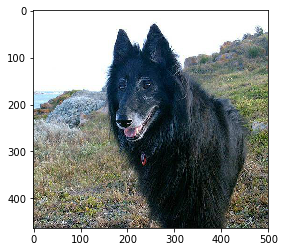

In [25]:
random_img = np.random.choice(listdir(join(data_dir,'train')))
random_img = join(data_dir, 'train', random_img)
mimg = mpimg.imread(random_img)
plt.imshow(mimg)

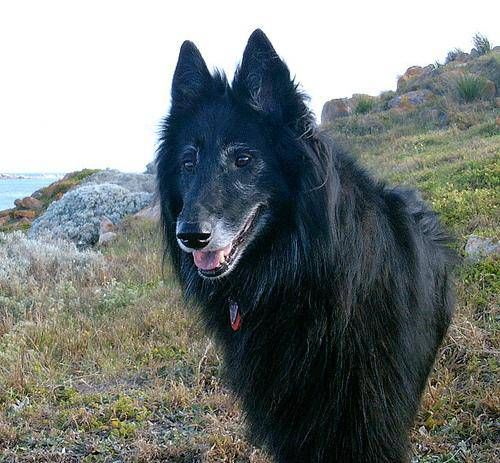

In [26]:
from IPython.display import Image
Image(random_img)

In [27]:
selected_breed_list = labels.breed.value_counts().index.values[:NUM_CLASSES]
selected_breed_list = list(selected_breed_list)

In [28]:
labels = labels[labels.breed.isin(selected_breed_list)]

In [29]:
# labels['target'] = 1
# labels['rank'] = labels.groupby('breed').rank()['id']
# labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
# y_train = labels_pivot[selected_breed_list].values

y_train = pd.get_dummies(labels.breed).values

In [30]:
le = LabelEncoder()
y_train_encode = le.fit_transform(labels.breed.values)

In [31]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))

train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [32]:
def read_img(img_id, train_or_test, size):
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

### ResNet50 class predictions for example images

In [17]:
model = ResNet50(weights='imagenet')

scottish_deerhound umbrella 0.372516


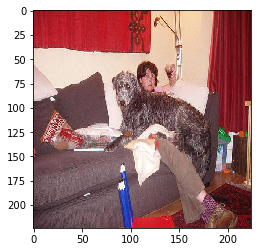

scottish_deerhound Scottish_deerhound 0.91279


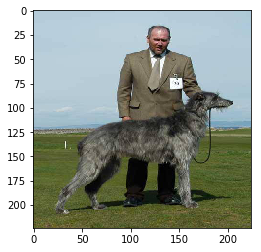

scottish_deerhound Scottish_deerhound 0.99251


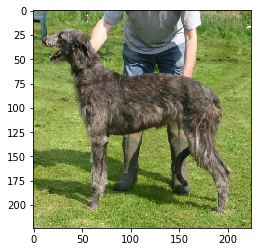

bernese_mountain_dog groenendael 0.471836


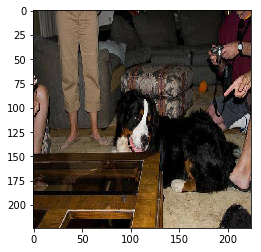

shih-tzu Shih-Tzu 0.771332


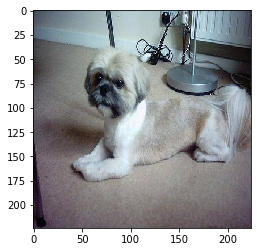

In [18]:
for row in labels.iloc[np.random.choice(len(labels), 5)].iterrows():
    img_id = row[1]['id']
    breed = row[1]['breed']
    img = read_img(img_id, 'train', (224, 224))
    x = np.expand_dims(img, axis=0)
    preds = model.predict(x)
    
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    print(breed, imagenet_class_name, prob)
    plt.imshow(-img)
    plt.show()

### Extract VGG16 bottleneck features

In [19]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.empty((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')

for i, img_id in enumerate(labels['id']):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(img)
    x_train[i] = x

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]

In [ ]:
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

In [21]:
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)

151/151 [==============================] - 2s     


In [22]:
train_vgg_bf.shape, valid_vgg_bf.shape

((549, 512), (151, 512))

### LogReg on VGG bottleneck features

In [23]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, y_train_encode[train_idx])

valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

In [24]:
log_loss(yv, valid_probs)

0.39152348649606344

In [25]:
accuracy_score(y_train_encode[valid_idx], valid_preds)

0.89403973509933776

### Extract Xception bottleneck features

In [33]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.empty((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')

for i, img_id in enumerate(labels['id']):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(img)
    x_train[i] = x

In [34]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]

In [35]:
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)

ResourceExhaustedError: OOM when allocating tensor with shape[1,1,728,728]
	 [[Node: block4_sepconv2_1/random_uniform_1/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=6496352, _device="/job:localhost/replica:0/task:0/gpu:0"](block4_sepconv2_1/random_uniform_1/shape)]]

Caused by op 'block4_sepconv2_1/random_uniform_1/RandomUniform', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-a125d6c3494d>", line 1, in <module>
    xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
  File "/opt/conda/lib/python3.6/site-packages/keras/applications/xception.py", line 184, in Xception
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 575, in __call__
    self.build(input_shapes[0])
  File "/opt/conda/lib/python3.6/site-packages/keras/layers/convolutional.py", line 1199, in build
    constraint=self.pointwise_constraint)
  File "/opt/conda/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/engine/topology.py", line 396, in add_weight
    weight = K.variable(initializer(shape),
  File "/opt/conda/lib/python3.6/site-packages/keras/initializers.py", line 212, in __call__
    dtype=dtype, seed=self.seed)
  File "/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3544, in random_uniform
    dtype=dtype, seed=seed)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 247, in _random_uniform
    seed=seed, seed2=seed2, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,1,728,728]
	 [[Node: block4_sepconv2_1/random_uniform_1/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=6496352, _device="/job:localhost/replica:0/task:0/gpu:0"](block4_sepconv2_1/random_uniform_1/shape)]]


In [ ]:
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)

### LogReg on Xception bottleneck features

In [27]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, y_train_encode[train_idx])

valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

In [28]:
log_loss(yv, valid_probs)

0.35418492029974241

In [29]:
accuracy_score(y_train_encode[valid_idx], valid_preds)

0.8861671469740634

### Extract Inception bottleneck features

In [ ]:
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)

2082/2082 [==============================] - 20s    


### LogReg on Inception bottleneck features

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, y_train_encode[train_idx])
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

In [ ]:
log_loss(yv, valid_probs)

In [ ]:
accuracy_score(y_train_encode[valid_idx], valid_preds)

### LogReg on all bottleneck features

In [ ]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, y_train_encode[train_idx])
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)

In [44]:
log_loss(yv, valid_probs)

0.31179595936369336

In [45]:
accuracy_score(y_train_encode[valid_idx], valid_preds)

0.89961575408261285

### Check errors

In [ ]:
valid_idx_num = np.where(valid_idx)[0]

In [ ]:
valid_breeds = y_train_encode[valid_idx]
error_idx = (valid_breeds != valid_preds)

In [ ]:
error_idx_num = np.where(error_idx)[0]

In [ ]:
error_idx_global_num = valid_idx_num[error_idx]

In [ ]:
for i, j in zip(error_idx_num, error_idx_global_num):
    pred_breed = le.inverse_transform(valid_preds[i])
    row = labels.iloc[j]
    img_id = row['id']
    breed = row['breed']
    img = read_img(img_id, 'train', (224, 224))
    print(breed, pred_breed, prob)
    plt.imshow(-img)
    plt.show()

### predict test data

In [62]:
test_ids = [file.split('.')[0] for file in listdir(data_dir+'/test')]

In [105]:
INPUT_SIZE = 299
POOLING = 'avg'
x_test = np.empty((len(test_ids), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')

for i, img_id in enumerate(test_ids):
    img = read_img(img_id, 'test', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(img)
    x_test[i] = (x)

In [106]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
test_i_bf = inception_bottleneck.predict(x_test, batch_size=32, verbose=1)
X_test = np.hstack([test_x_bf, test_i_bf])
valid_probs = logreg.predict_proba(X_test)
valid_preds = logreg.predict(X_test)

10357/10357 [==============================] - 100s   


### submit

In [107]:
ls $data_dir

labels.csv  results/  sample_submission.csv  test/  train/


In [108]:
!wc -l $data_dir/sample_submission.csv

10358 /opt/notebooks/data/dog-breed-identification/unzipped/sample_submission.csv


In [109]:
subm=pd.DataFrame(np.hstack([np.array(test_ids).reshape(-1, 1), valid_probs]))

In [110]:
cols = ['id']+list(le.inverse_transform(range(NUM_CLASSES)))

subm.columns = cols

submission_file_name = data_dir+'/results/belugatest%s.csv' % datetime.now().strftime('%Y-%m-%d-%H-%M')

subm.to_csv(submission_file_name, index=False)

In [111]:
!kg config -g -u $KAGGLE_USER -p $KAGGLE_PW -c $competition_name
!kg submit $submission_file_name -u $KAGGLE_USER -p $KAGGLE_PW -m "Test"

list index out of range


Your submission scored 0.29973